 # Episodically Diminishing

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
223
Solved after 1341 episodes.
-64.0


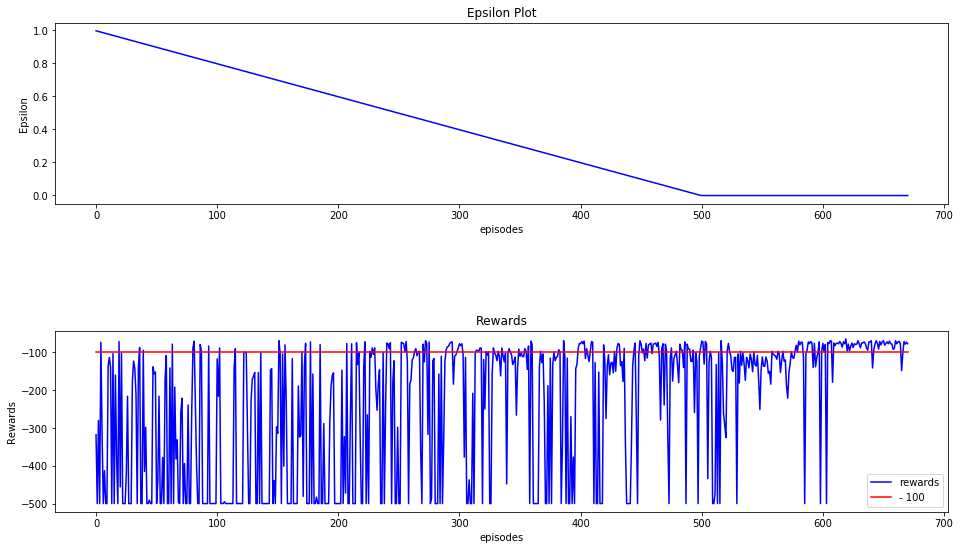

In [8]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')

class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        return
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
            #print(step_size)
        elif t > 0:
            #bottom = t ** self.beta
            step_size = self.alpha / (t ** self.beta)  
            #alpha [0,1), beta (.5, 1] respectively
            # .9, .9 worked well once 
            #print(step_size)
        return step_size

#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        times = 0
        listof50 = deque(maxlen=100)
        j = 0
        #episodes = []
        # this part until the end of the while loop:
        # this is the part of the function that trains the enviornment.
        for e in range(self.max_episodes):  
            if e % 50 == 0:
                print(e)
            # As states are continuous, discretize them into buckets
            # for each episode the enviornment resets and discretizes the state
            state = self.discretize(self.env.reset())
            #print(self.env.reset())
            #epsilon = self.epsilon
            epsilon = self.decay_epsilon()
            #print("epsilon", epsilon)
            step_size = self.decay_step_size(e)
            #print("alpha", alpha)
            i = 0
            for t in range(self.max_steps):
                #step_size = self.decay_step_size(e)
                #self.env.render()
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                #print(reward)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward  #-1 for each timestep the agent takes to swing up  # reward threshold -100
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable>=-500)
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                epsilonList.append(epsilon)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
                    #print(str(e) + " episodes: " + str(i) + " reward")
                if mean_listof50 >= -100 and e >= 50:
                    print(times)
                    print("Solved after " + str(e) + " episodes.")
                    return rewards, alphaList, epsilonList
        print(times)
        #print(self.QTable)
        return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    print(max(rewards))
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    plt1 = fig.add_subplot(211)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    """plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    #plt3.set_yticks(np.arange(min(rewards), max(rewards)+100, 100.0), minor=False)
    #ax3.yticks(np.arange(min(rewards), max(rewards)+10, 10.0))
    fig.subplots_adjust(hspace=0.7)
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()

# Constant Step Size

68
Solved after 173 episodes.
-68.0


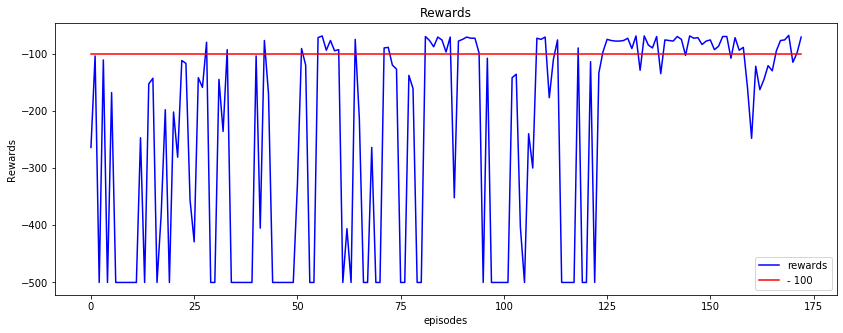

In [12]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''
#(2, 2, 3, 3, 6, 12)
#(1, 1, 1, 1, 16, 12) !!!!!!!!!!!!!!!!!!
#(1, 1, 1, 1, 12, 14)--> works well!!!
#(1,1,1,1,6,12(13,14))
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, step_size=0.01, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.step_size = step_size
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        return
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon


#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        times = 0
        listof50 = deque(maxlen=50)
        #episodes = []
        # this part until the end of the while loop:
        # this is the part of the function that trains the enviornment.
        for e in range(self.max_episodes):  
            # As states are continuous, discretize them into buckets
            # for each episode the enviornment resets and discretizes the state
            state = self.discretize(self.env.reset())
            #epsilon = self.epsilon
            epsilon = self.decay_epsilon()
            #print("epsilon", epsilon) 
            #print("alpha", alpha)
            i = 0
            for t in range(self.max_steps):
                #step_size = self.decay_step_size(e)
                #self.env.render()
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                #print(reward)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, self.step_size)
                state = new_state
                i += reward  #-1 for each timestep the agent takes to swing up  # reward threshold -100
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable>=-500)
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(self.step_size)
                epsilonList.append(epsilon)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
                    #print(str(e) + " episodes: " + str(i) + " reward")
                if mean_listof50 >= -100 and e >= 50:
                    print(times)
                    print("Solved after " + str(len(rewards)) + " episodes.")
                    return rewards, alphaList, epsilonList
        print(times)
        #print(self.QTable)
        return rewards, alphaList, epsilonList


        print(times)
        return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    print(max(rewards))
    #moving_ave = solve.moving_average(rewards)
    fig = plt.figure(figsize=(14,5)) #(14, 5)
    #plt.title('Acrobot-v1')
    """plt1 = fig.add_subplot(311)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(111)
    plt3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    #plt3.set_yticks(np.arange(min(rewards), max(rewards)+100, 100.0), minor=False)
    #ax3.yticks(np.arange(min(rewards), max(rewards)+10, 10.0))
    fig.subplots_adjust(hspace=0.7)
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()

# Continually Diminishing

415
Solved after 884 episodes.
-68.0


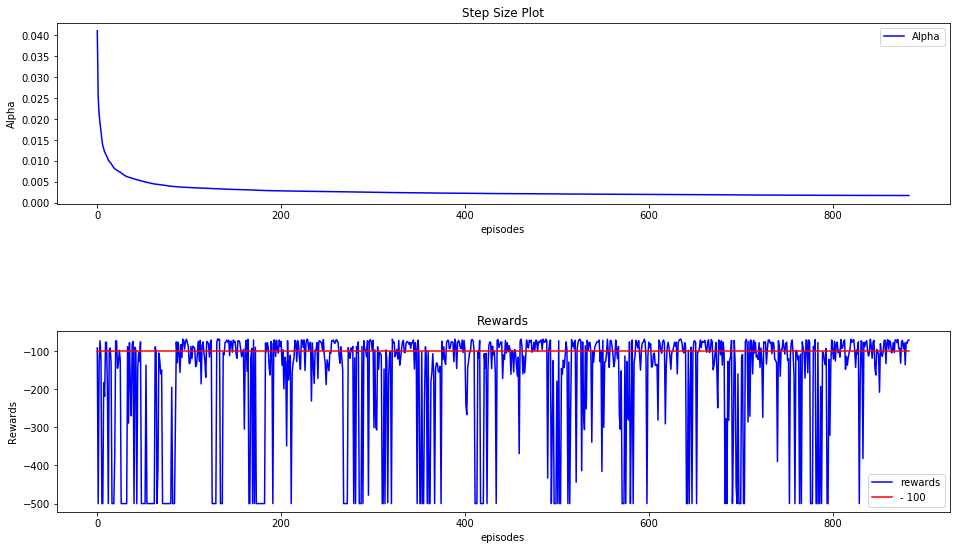

In [13]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''
#(2, 2, 3, 3, 6, 12)
#(1, 1, 1, 1, 16, 12)
#(1, 1, 1, 1, 12, 14)--> works well!!!
#(1,1,1,1,6,12(13,14))
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
   
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        return
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, tt, e, t):
        num = self.alpha
        dem = tt**self.beta
        if e == 0 and t == 0:
            step_size = 1
        elif tt > 0:
            step_size = num / dem
        return step_size

#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        times = 0
        listof50 = deque(maxlen=50)
        tt = 0
        #episodes = []
        # this part until the end of the while loop:
        # this is the part of the function that trains the enviornment.
        for e in range(self.max_episodes): 
            # As states are continuous, discretize them into buckets
            # for each episode the enviornment resets and discretizes the state
            state = self.discretize(self.env.reset())
            #epsilon = self.epsilon
            epsilon = self.decay_epsilon()
            #print("epsilon", epsilon)
            #step_size = self.decay_step_size(e)
            #print("alpha", alpha)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(tt, e, t)
                tt += 1
                #step_size = self.decay_step_size(e)
                #self.env.render()
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                #print(reward)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward  #-1 for each timestep the agent takes to swing up  # reward threshold -100
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable>=-500)
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                epsilonList.append(epsilon)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
                    #print(str(e) + " episodes: " + str(i) + " reward")
                if mean_listof50 >= -100 and e >= 50:
                    print(times)
                    print("Solved after " + str(len(rewards)) + " episodes.")
                    return rewards, alphaList, epsilonList
        print(times)
        return rewards, alphaList, epsilonList
    def moving_average(self, rewards, window_size = 10): #A specified window size determines the size of each subset.
        #In statistics, a moving average (rolling average or running average)
        #is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. 
        #The moving average is calculated by adding the rewards over a certain period 
        #and dividing the sum by the total number of periods.
        sum_vec = np.cumsum(np.insert(rewards, 0, 0))  
        moving_ave = (sum_vec[window_size:] - sum_vec[:-window_size]) / window_size  #formula for moving average
        return moving_ave


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    print(max(rewards))
    moving_ave = solve.moving_average(rewards)
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    #plt.title('Acrobot-v1')
    """plt1 = fig.add_subplot(311)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')"""
    plt2 = fig.add_subplot(211)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')   
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    #plt3.set_yticks(np.arange(min(rewards), max(rewards)+100, 100.0), minor=False)
    #ax3.yticks(np.arange(min(rewards), max(rewards)+10, 10.0))
    fig.subplots_adjust(hspace=0.7)
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    #plt1.legend(loc='best')
    plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()

# Restarting Diminishing Step

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
306
-69.0


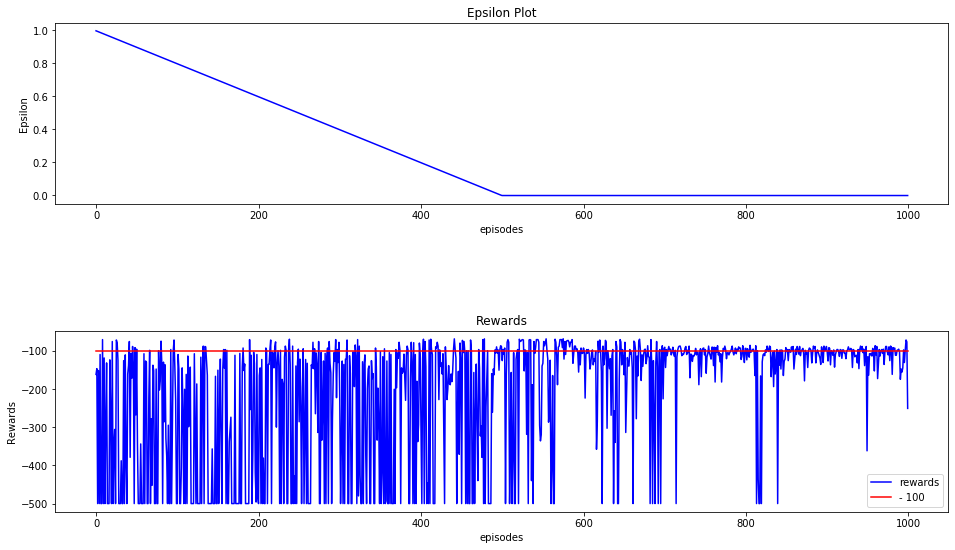

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

#Acrobot does not have threshold at which it is considered solved.
'''This environment consists of a two link, two joint robot.
The joint between the links is actuated. At the start of the episode,
the links are hanging downwards. At every timestep the agent chooses
an action that correspond to applying a force to move the actuated
link to the right, to the left, or to not applying a force.
The episode is over once the end of the lower link swings above a certain
height.The goal is to end the episode in the fewest possible timesteps.
We use the OpenAI Gym ‘Acrobot-v1’ environment. This implementation is
based on the system presented in (Geram- ifard et al., 2015).
Each observation is a set consisting of readings from six sensors,
corresponding to the rotational joint angles and velocities of joints and links.
The action space is discrete with three elements, and at each timestep
the environment returns the observation and a reward of -1. 
An episode is terminated after 200 time steps irrespective of
the state of the robot. This is an unsolved environment,
which means it does not have a specified reward threshold at which
it’s considered solved.'''
#(2, 2, 3, 3, 6, 12)
#(1, 1, 1, 1, 16, 12) !!!!!!!!!!!!!!!!!!
#(1, 1, 1, 1, 12, 14)--> works well!!!
#(1,1,1,1,6,12(13,14))
class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.0, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 6 x 12 x 2)
        self.alpha = 1 # learning rate
        self.beta = 0.5

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        return
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    def decay_epsilon(self):
        epsilon = self.epsilon - 0.001
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
            #print(step_size)
        elif t > 0:
            #bottom = t ** self.beta
            step_size = self.alpha / (t ** self.beta)  
            #alpha [0,1), beta (.5, 1] respectively
            # .9, .9 worked well once 
            #print(step_size)
        return step_size

#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        times = 0
        listof50 = deque(maxlen=100)
        j = 0
        #episodes = []
        # this part until the end of the while loop:
        # this is the part of the function that trains the enviornment.
        for e in range(self.max_episodes):  
            if e % 50 == 0:
                print(e)
            # As states are continuous, discretize them into buckets
            # for each episode the enviornment resets and discretizes the state
            state = self.discretize(self.env.reset())
            #print(self.env.reset())
            #epsilon = self.epsilon
            epsilon = self.decay_epsilon()
            #print("epsilon", epsilon)
            step_size = 1 #self.decay_step_size(e)
            #print("alpha", alpha)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                #self.env.render()
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                #print(reward)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward  #-1 for each timestep the agent takes to swing up  # reward threshold -100
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable >= -600)
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            del stateList[1::3]
            del stateList[1::2]
            #print(len(actionsList), len(stateList))
            policy = dict(zip(stateList, actionsList))
            #print(policy)
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                epsilonList.append(epsilon)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
                    #print(str(e) + " episodes: " + str(i) + " reward")
                if mean_listof50 >= -100 and e >= 50:
                    print(times)
                    print("Solved after " + str(e) + " episodes.")
                    return rewards, alphaList, epsilonList
        print(times)
        #print(self.QTable)
        return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    print(max(rewards))
    #moving_ave = solve.moving_average(rewards)
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    #plt.title('Acrobot-v1')
    plt1 = fig.add_subplot(211)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    """plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    #plt3.set_yticks(np.arange(min(rewards), max(rewards)+100, 100.0), minor=False)
    #ax3.yticks(np.arange(min(rewards), max(rewards)+10, 10.0))
    fig.subplots_adjust(hspace=0.7)
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()